# 3DRDNN

Main pipeline for research in my Master.

## goals in this notebook

Prepare the pipeline for any 3d DNN to train on CT data.
1) data loader
2) DNN
3) Training
4) Results comparison

In [1]:
# Testing reading GPU
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np

# Check TensorFlow Version
print("TensorFlow Version: {}".format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn("No GPU found. Please ensure you have installed TensorFlow correctly")
else:
    print(tf.test.gpu_device_name())

TensorFlow Version: 2.10.1
/device:GPU:0


In [2]:
# datasets for tf
from data_preprocessing_3d import get_dataset_large

batch_size = 4
dataset = get_dataset_large(
    r"C:\Users\kaczm\programming\3DRDNN\data\LITS_TFRecords\train"
)
dataset = dataset.shuffle(8).batch(batch_size)
valid_dataset = get_dataset_large(
    r"C:\Users\kaczm\programming\3DRDNN\data\LITS_TFRecords\valid"
)
valid_dataset = valid_dataset.batch(
    batch_size
)  # .shuffle(1000,  reshuffle_each_iteration=True)

for sample in dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)

for sample in valid_dataset.take(10):
    print(sample[0].shape)
    print(sample[1].shape)
    print(np.min(sample[0]))
    print(np.max(sample[0]))

print(dataset)
print(valid_dataset)


['C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images0.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images1.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images2.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images3.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images4.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images5.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images6.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images7.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images8.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\train\\images9.tfrecords']
['C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords\\valid\\images10.tfrecords', 'C:\\Users\\kaczm\

In [3]:
### learning rate schedule


def scheduler(epoch, lr):
    if epoch < 2:
        lr = 0.001
        return lr
    else:
        return lr * tf.math.exp(-0.05)

In [3]:
# Network set-up
from utils import models

model = models.model_call(model_name="3DUNET", pxz=32, px=64, features=32)


In [4]:
# Metrics and training

adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)
precision_all = tf.keras.metrics.Precision(thresholds=0.5)
precision = tf.keras.metrics.Precision(thresholds=0.5, class_id=1)
recall = tf.keras.metrics.Recall(thresholds=0.5, class_id=1)

model.compile(
    loss="categorical_crossentropy",
    optimizer=adam,
    metrics=[precision_all, precision, recall],
)
model.summary(positions=[0.33, 0.66, 0.78, 1.0])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_1 (InputLayer)           [(None, 32, 64, 64, 1)]         0           []                    
                                                                                                  
 conv3d (Conv3D)                (None, 32, 64, 64, 32)          896         ['input_1[0][0]']     
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 64, 64, 32)         128         ['conv3d[0][0]']      
 alization)                                                                                       
                                                                                                  
 conv3d_1 (Conv3D)              (None, 32, 64, 64, 64)          18496       ['batch_normalizat

In [202]:
# Results
# reading checkpoint if needen
#
#################################
import pandas as pd
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    # ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    ModelCheckpoint(
        "models\\3DUNET_lesion_32_32_64\\epoch-{epoch:02d}-valloss-{val_loss:.4f}-{val_precision_1:.2f}-{val_recall:.2f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
    ),
    TerminateOnNaN(),
]
epochs = 30

history = model.fit(
    dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0,
)


hist_df = pd.DataFrame(history.history)

# save to json:
hist_json_file = "history.json"
with open(hist_json_file, mode="w") as f:
    hist_df.to_json(f)

# or save to csv:
hist_csv_file = "history.csv"
with open(hist_csv_file, mode="w") as f:
    hist_df.to_csv(f)


Epoch 1/30


KeyboardInterrupt: 

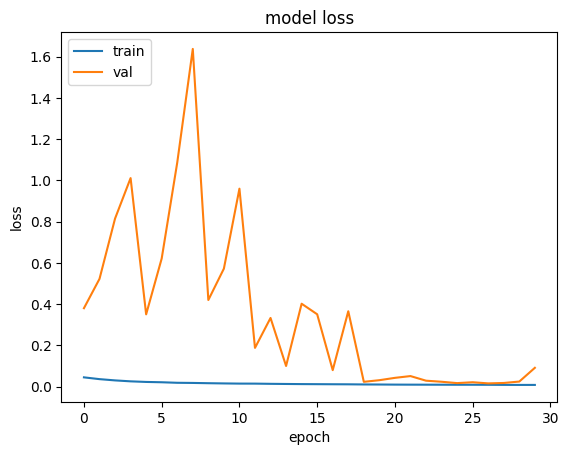

INFO:tensorflow:Assets written to: ram://ad702f97-a4e1-4759-9d76-acc0a704cf80/assets


In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

np.save("3Dunet_history_lesion.npy", np.array(history))


In [ ]:
# a zrób testowy trening od modelu do wątroby :))) mnoże będzie lepiej!


In [5]:
model.load_weights(r"models\\3DUNET_lesion_32_32_64\\epoch-23-valloss-0.0288-0.72-0.74.hdf5")
#model.load_weights(
#    r"models\\3DUNET_lesion_32_32_64\\epoch-27-valloss-0.0158-0.69-0.77.hdf5"
#)


# model.evaluate(valid_dataset)

In [6]:
# let's start with normal image and make some predictions

import SimpleITK as sitk
import glob
from tqdm import tqdm

# load .nii file

# def few funtion to make predictions, WIP, they will be later added to Nii class


def preprocessing_3d(t1) -> np.ndarray:
    min = -200
    max = 200
    t1 = np.where(t1 < min, min, t1)
    t1 = np.where(t1 > max, max, t1)
    t1 -= min
    return t1 / max


def label_seperator_liver(img):
    img = np.where(img == 2, 1, img)
    return img


def label_seperator_lesion(img):
    img = np.where(img == 1, 0, img)
    img = np.where(img == 2, 1, img)
    return img


def reading_data(path: str) -> np.ndarray:
    sitk_t1 = sitk.ReadImage(path)
    t1 = sitk.GetArrayFromImage(sitk_t1)
    t1 = t1.reshape(t1.shape[0], t1.shape[1], t1.shape[2], 1)

    t1 = tf.dtypes.cast(t1, tf.float32)

    return t1


def label_seperator_liver(img):
    img = np.where(img == 2, 1, img)
    return img


path = "data\\LITS_Challenge\\Training_Batch_1"
files_volume = glob.glob(path + "\\volume*.nii")
files_segmenation = glob.glob(path + "\\segmentation*.nii")

print(files_volume[0])
print(files_segmenation[0])

data\LITS_Challenge\Training_Batch_1\volume-0.nii
data\LITS_Challenge\Training_Batch_1\segmentation-0.nii


In [6]:

file_id = 8
volume_1 = reading_data(files_volume[file_id])
volume_1 = preprocessing_3d(volume_1)
print(np.min(volume_1))
print(np.max(volume_1))


seg_1 = reading_data(files_segmenation[file_id])
liver_1 = label_seperator_liver(seg_1)
seg_1 = label_seperator_lesion(seg_1)
seg_1 = tf.keras.utils.to_categorical(seg_1, 2)
print(volume_1.shape)
print(liver_1.shape)
print(seg_1.shape)


volume_1 = np.where(liver_1 > 0, volume_1, 0)

0.0
2.0
(689, 512, 512, 1)
(689, 512, 512, 1)
(689, 512, 512, 2)


In [7]:
# 1) going from top to the bottom, all slices even without the liver
# data preparation -> spreading data to quboids

def get_prediction(volume_1,seg_1):
    n = (volume_1.shape[0] // 32) * 2 - 1
    m = (volume_1.shape[1] // 64) * 2 - 1

    chunk_size = 32
    cords_shift = chunk_size // 2

    #print(chunk_size)
    #print(cords_shift)

    total_q = n * m * m  # total quboids

    all_quboids = np.zeros(
        (int(total_q // 4 + 1), 4, chunk_size, chunk_size * 2, chunk_size * 2, 1)
    )
    all_quboids_seg = np.zeros(
        (int(total_q // 4 + 1), 4, chunk_size, chunk_size * 2, chunk_size * 2, 2)
    )
    preds = np.zeros(
        (int(total_q // 4 + 1), 4, chunk_size, chunk_size * 2, chunk_size * 2, 2)
    )
    #print(all_quboids.shape)
    batch_no = 0
    q = 0
    for z in range(n):  # z direction
        for y in range((m)):
            for x in range((m)):
                tmp_image = volume_1[
                    z * cords_shift : z * cords_shift + chunk_size,
                    y * cords_shift * 2 : y * cords_shift * 2 + chunk_size * 2,
                    x * cords_shift * 2 : x * cords_shift * 2 + chunk_size * 2,
                    0:1,
                ]

                tmp_seg = seg_1[
                    z * cords_shift : z * cords_shift + chunk_size,
                    y * cords_shift * 2 : y * cords_shift * 2 + chunk_size * 2,
                    x * cords_shift * 2 : x * cords_shift * 2 + chunk_size * 2,
                    0:2,
                ]

                all_quboids[batch_no, q, :, :, :, 0:1] = tmp_image
                all_quboids_seg[batch_no, q, :, :, :, 0:2] = tmp_seg
                q += 1
                if q > 3:
                    batch_no += 1
                    q = 0

                """
                tmp_seg = seg_1[
                    z * cords_shift : z * cords_shift + chunk_size,
                    y * cords_shift * 2 : y * cords_shift * 2 + chunk_size * 2,
                    x * cords_shift * 2 : x * cords_shift * 2 + chunk_size * 2,
                    0:2,
                ]"""


    # prediction for whole


    for i in tqdm(range(len(all_quboids))):
        if np.any(all_quboids[i] > 0):
            preds[i] = model.predict(all_quboids[i],verbose=0)

    #print(preds.shape)
    #print("done")

    a = 0
    final_preds = np.zeros((np.shape(seg_1)))
    #print(final_preds.shape)
    i = 0
    j = 0
    for z in range(n):  # z direction
        for y in range((m)):
            for x in range((m)):
                final_preds[
                    z * cords_shift: z * cords_shift + chunk_size,
                    y * cords_shift * 2: y * cords_shift * 2 + chunk_size * 2,
                    x * cords_shift * 2: x * cords_shift * 2 + chunk_size * 2,
                    0:2,
                ] += preds[i, j, :, :, :, 0:2]
                j += 1
                if j > 3:
                    i += 1
                    j = 0

                a += 1


    final_preds = final_preds / 8
    return final_preds

In [8]:
def get_metrics(liver,gt,preds,thresholds=0.5):
    TP = tf.keras.metrics.TruePositives(thresholds=thresholds)
    FP = tf.keras.metrics.FalsePositives(thresholds=thresholds)
    FN = tf.keras.metrics.FalseNegatives(thresholds=thresholds)
    
    preds = preds[:,:,:,1]
    preds = np.where(liver[:,:,:,0]>0,preds,0)

    TP.update_state(gt[:, :, :, 1], preds)
    FP.update_state(gt[:, :, :, 1], preds)
    FN.update_state(gt[:, :, :, 1], preds)

    prec = TP.result() / (TP.result() + FP.result())
    recall = TP.result() / (TP.result() + FN.result())
    return prec, recall

In [47]:

plt.rcParams["figure.figsize"] = (20, 15)

for i in range(np.shape(volume_1)[0]):
    if np.any(volume_1[i, :, :, 0]) > 0 and np.any(seg_1[i, :, :, 1]) > 0.1:

        plt.subplot(1, 3, 1)
        plt.imshow(volume_1[i, :, :, 0])
        plt.title("original volume")
        plt.grid()
        plt.subplot(1, 3, 2)
        plt.title("combined predictions")
        plt.imshow(lesion[i, :, :], vmin=0.07, vmax=0.2)
        plt.grid()
        plt.subplot(1, 3, 3)
        plt.title("ground truth")
        plt.imshow(seg_1[i, :, :, 1])
        plt.grid()
        plt.suptitle(f"{volume_1.shape[0]}_{i}, precition:{np.round(prec,2)} recall {np.round(recall,2)}")
        plt.savefig(f"results_images/{volume_1.shape[0]}_{i}.png")
        plt.close()




ValueError: operands could not be broadcast together with shapes (75,512,512) (517,512,512) () 

In [9]:
# Metrics loop

plotting = False
idxxxx = [8,9,12]
for file_id in idxxxx:

    #file_id = 8


    threshold = 0.3

    volume_1 = reading_data(files_volume[file_id])
    volume_1 = preprocessing_3d(volume_1)


    seg_1 = reading_data(files_segmenation[file_id])
    liver_1 = label_seperator_liver(seg_1)
    seg_1 = label_seperator_lesion(seg_1)
    seg_1 = tf.keras.utils.to_categorical(seg_1, 2)
    volume_1 = np.where(liver_1 > 0, volume_1, 0)
    print("get volume is ok")
    final_preds = get_prediction(volume_1,seg_1)
    print("preds are ok")

    plt.rcParams["figure.figsize"] = (20, 15)

    lesion = final_preds[:, :, :, 0:1]
    lesion = np.where(liver_1 > 0, final_preds, 0)
    lesion = lesion[:, :, :, 1]

    print("lesion is ok")
    prec, recall = get_metrics(volume_1,seg_1,final_preds,threshold)
    print("metrics are ok")

    # lesion = np.where(lesion>threshold,1,0)
    if plotting:
        for i in range(np.shape(volume_1)[0]):
            if np.any(volume_1[i, :, :, 0]) > 0 and np.any(seg_1[i, :, :, 1]) > 0.1:

                plt.subplot(1, 3, 1)
                plt.imshow(volume_1[i, :, :, 0])
                plt.title("original volume")
                plt.grid()
                plt.subplot(1, 3, 2)
                plt.title("combined predictions")
                plt.imshow(lesion[i, :, :], vmin=threshold, vmax=threshold+0.01)
                plt.grid()
                plt.subplot(1, 3, 3)
                plt.title("ground truth")
                plt.imshow(seg_1[i, :, :, 1])
                plt.grid()
                plt.suptitle(f"{file_id}_{volume_1.shape[0]}_{i}, precition:{np.round(prec,2)} recall {np.round(recall,2)}")
                plt.savefig(f"results_images/{file_id}_{volume_1.shape[0]}_{i}.png")
                plt.close()



    #with open("results.txt",'a+') as f:
    #    f.write(f"file_id: {file_id}, z: {volume_1.shape[0]}, prec: {np.round(prec,2)}, recall: {np.round(recall,2)}\n")

    print(prec, recall)
    np.save(f"{file_id}_preds.npy",final_preds)
    del volume_1
    del seg_1
    del final_preds
    
    print(f"done {file_id} and saved")

get volume is ok


100%|██████████| 2307/2307 [01:03<00:00, 36.60it/s] 


preds are ok
lesion is ok
metrics are ok
tf.Tensor(0.82719815, shape=(), dtype=float32) tf.Tensor(0.855562, shape=(), dtype=float32)
done 8 and saved
get volume is ok


100%|██████████| 2757/2757 [00:51<00:00, 53.95it/s]  


preds are ok
lesion is ok
metrics are ok
tf.Tensor(0.6348246, shape=(), dtype=float32) tf.Tensor(0.97436035, shape=(), dtype=float32)
done 9 and saved
get volume is ok


100%|██████████| 1744/1744 [00:41<00:00, 41.61it/s]  


preds are ok
lesion is ok
metrics are ok
tf.Tensor(0.74722224, shape=(), dtype=float32) tf.Tensor(0.81855494, shape=(), dtype=float32)
done 12 and saved


file_id: 0, z: 75, prec: 0.07000000029802322, recall: 0.0

file_id: 1, z: 123, prec: 0.5199999809265137, recall: 0.23000000417232513

file_id: 2, z: 501, prec: 0.5799999833106995, recall: 0.949999988079071

file_id: 3, z: 466, prec: 0.6399999856948853, recall: 0.8199999928474426

file_id: 4, z: 455, prec: 0.11999999731779099, recall: 0.3700000047683716

file_id: 5, z: 605, prec: 0.07000000029802322, recall: 0.6600000262260437

file_id: 6, z: 588, prec: 0.3100000023841858, recall: 0.8100000023841858

file_id: 7, z: 565, prec: 0.0, recall: 0.0

file_id: 8, z: 689, prec: 0.8600000143051147, recall: 0.8500000238418579

file_id: 9, z: 826, prec: 0.699999988079071, recall: 0.9800000190734863

file_id: 10, z: 845, prec: 0.7599999904632568, recall: 0.6800000071525574

file_id: 11, z: 547, prec: 0.30000001192092896, recall: 0.7200000286102295

file_id: 12, z: 517, prec: 0.7699999809265137, recall: 0.7900000214576721

file_id: 13, z: 574, prec: 0.019999999552965164, recall: 0.4300000071525574

file_id: 14, z: 437, prec: 0.7699999809265137, recall: 0.2199999988079071

file_id: 15, z: 247, prec: 0.47999998927116394, recall: 0.9900000095367432

file_id: 16, z: 391, prec: 0.5, recall: 1.0

file_id: 17, z: 276, prec: 0.0, recall: 0.0

file_id: 18, z: 601, prec: 0.1599999964237213, recall: 0.8600000143051147

file_id: 19, z: 668, prec: 0.6899999976158142, recall: 0.9900000095367432

file_id: 20, z: 861, prec: 0.6200000047683716, recall: 0.9399999976158142

file_id: 21, z: 534, prec: 0.33000001311302185, recall: 0.8100000023841858

file_id: 22, z: 841, prec: 0.75, recall: 0.9900000095367432

file_id: 23, z: 537, prec: 0.0, recall: 0.0

file_id: 24, z: 518, prec: 0.550000011920929, recall: 0.9900000095367432

file_id: 25, z: 541, prec: 0.6100000143051147, recall: 0.9900000095367432

file_id: 26, z: 541, prec: 0.5799999833106995, recall: 0.9700000286102295

file_id: 27, z: 549, prec: 0.5400000214576721, recall: 0.9900000095367432



In [12]:
# 2) only part with the liver




#TODO

# 1) zdefiniować liczenie metryk (tj metryki i z czego mają się liczyć)
# 2) przeliczyć dla każdego skanu
# 3) przeskalować małe skany na duże i przeliczyć znowu
# 4) pomyśleć jak można sprawdzać dice od wielkości

Wnioski:


- działa, cały pipeline działa
- sieć wymaga modyfikacji do tego podejścia

- wykrywa poprawie większe zmiany, nie wykrywa małych, jest to związane z architekturą sieci
-- do tego problemu trzeba to zrobić inaczej, więcej kanałów na normalnym poziomie, mniej na niższym, ew zrobić nawet jednopoziomowy encoder dekoder (i więcej cech)
- podejście nie wydaje się złe, tylko wymaga faktycznie dostosowania pod siebie kilku aspektów, szczególnie do szuaknia małych zmian

In [11]:
from skimage.measure import find_contours, label, regionprops
from tifffile import TiffFile, imwrite
from roifile import ImagejRoi
import cv2
def plot_image_overlays(image, overlays, **kwargs):
    """Plot image and overlays (bytes) using matplotlib."""
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray')
    if not isinstance(overlays, list):
        overlays = [overlays]
    for overlay in overlays:
        roi = ImagejRoi.frombytes(overlay)
        roi.plot(ax, **kwargs)
    plt.show()

(689, 512, 512, 1)
(512, 512)
870.0123214941705 ok countur
6707.537467976974 ok countur
63.49668886559084 ok countur
2.2817403078079224e-08 regected
0.0001983854454010725 regected
20.998077415395528 ok countur
194.50430299527943 ok countur


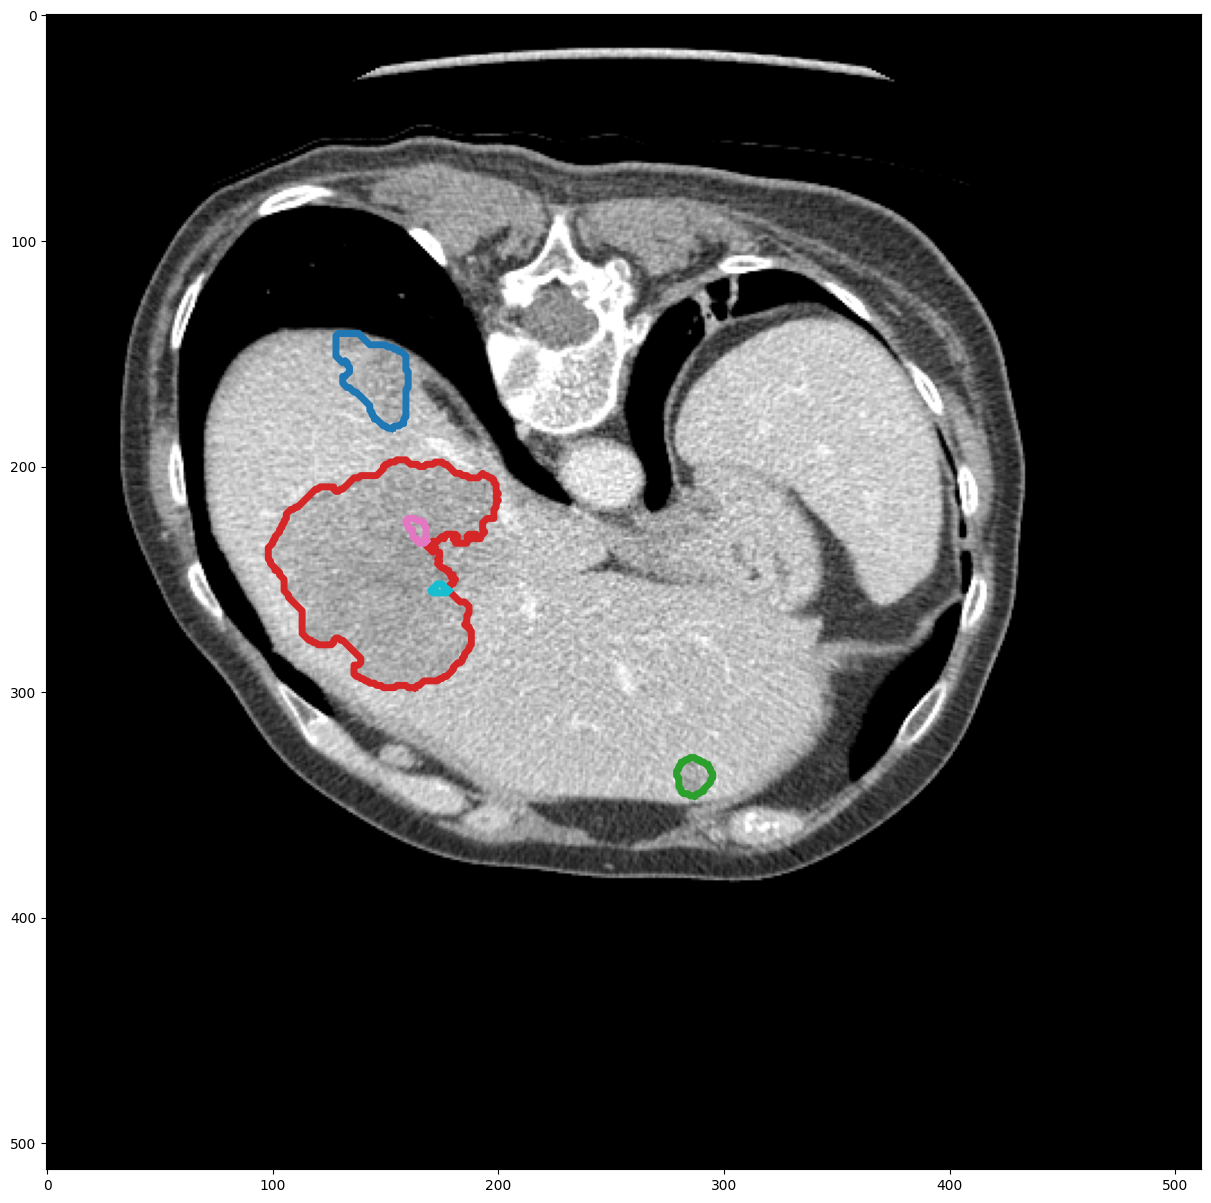

(826, 512, 512, 1)
(512, 512)
674.0093155119102 ok countur
2.1187588572502136e-08 regected
1016.01105501235 ok countur
0.000198382418602705 regected
0.000198382418602705 regected
1.816079020500183e-08 regected
1.816079020500183e-08 regected
1.816079020500183e-08 regected
0.000198382418602705 regected


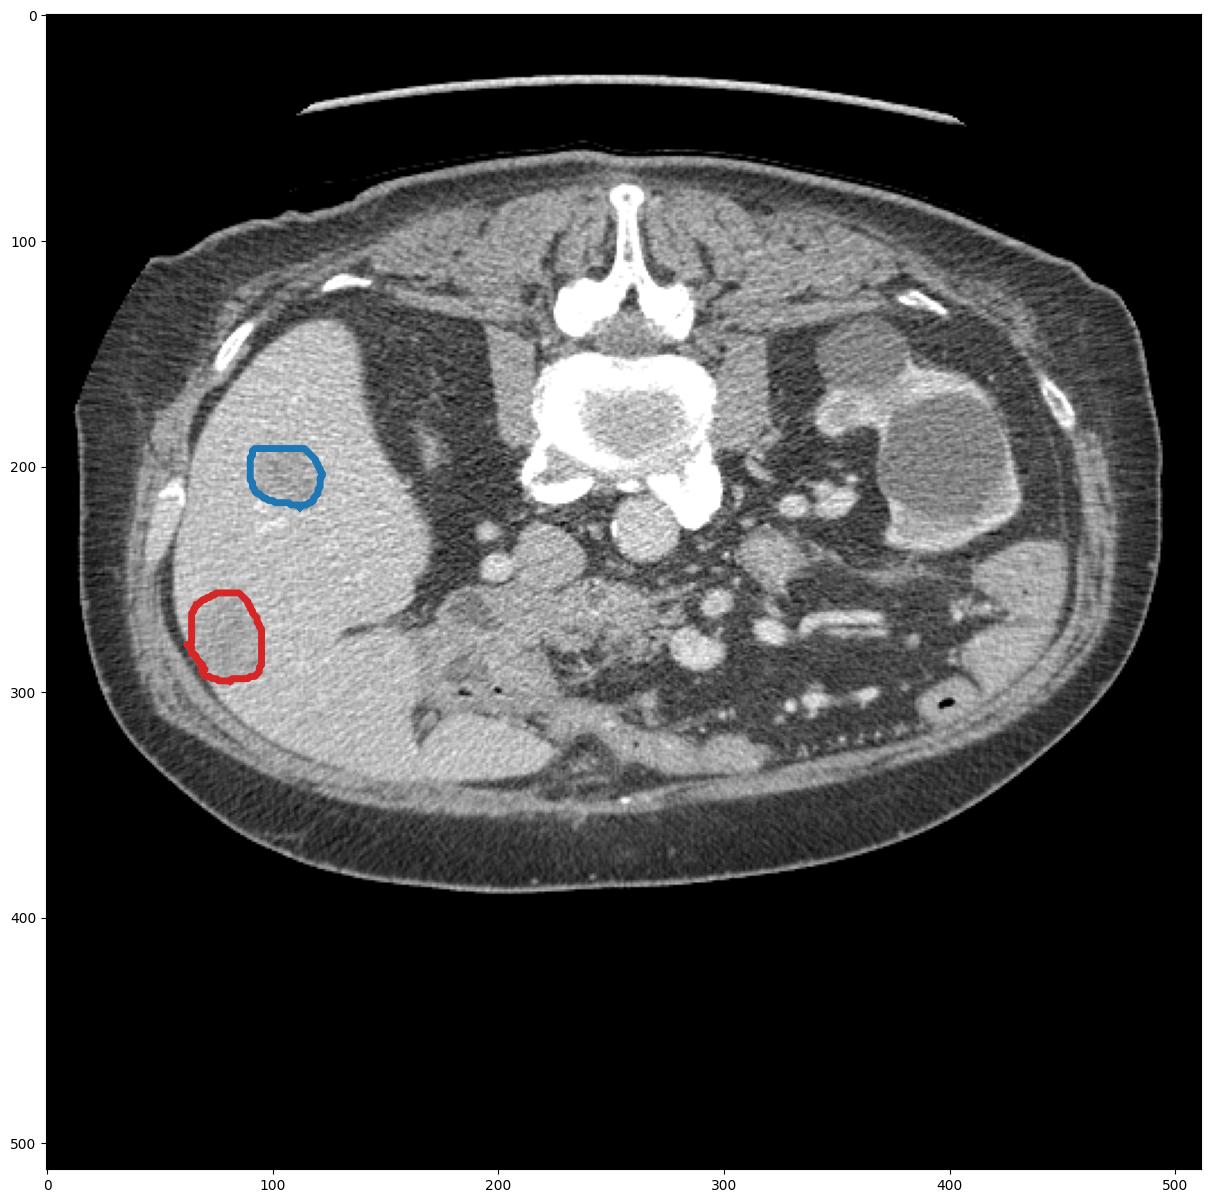

(517, 512, 512, 1)
(512, 512)
26.0022278027609 ok countur
0.00021364260464906693 regected


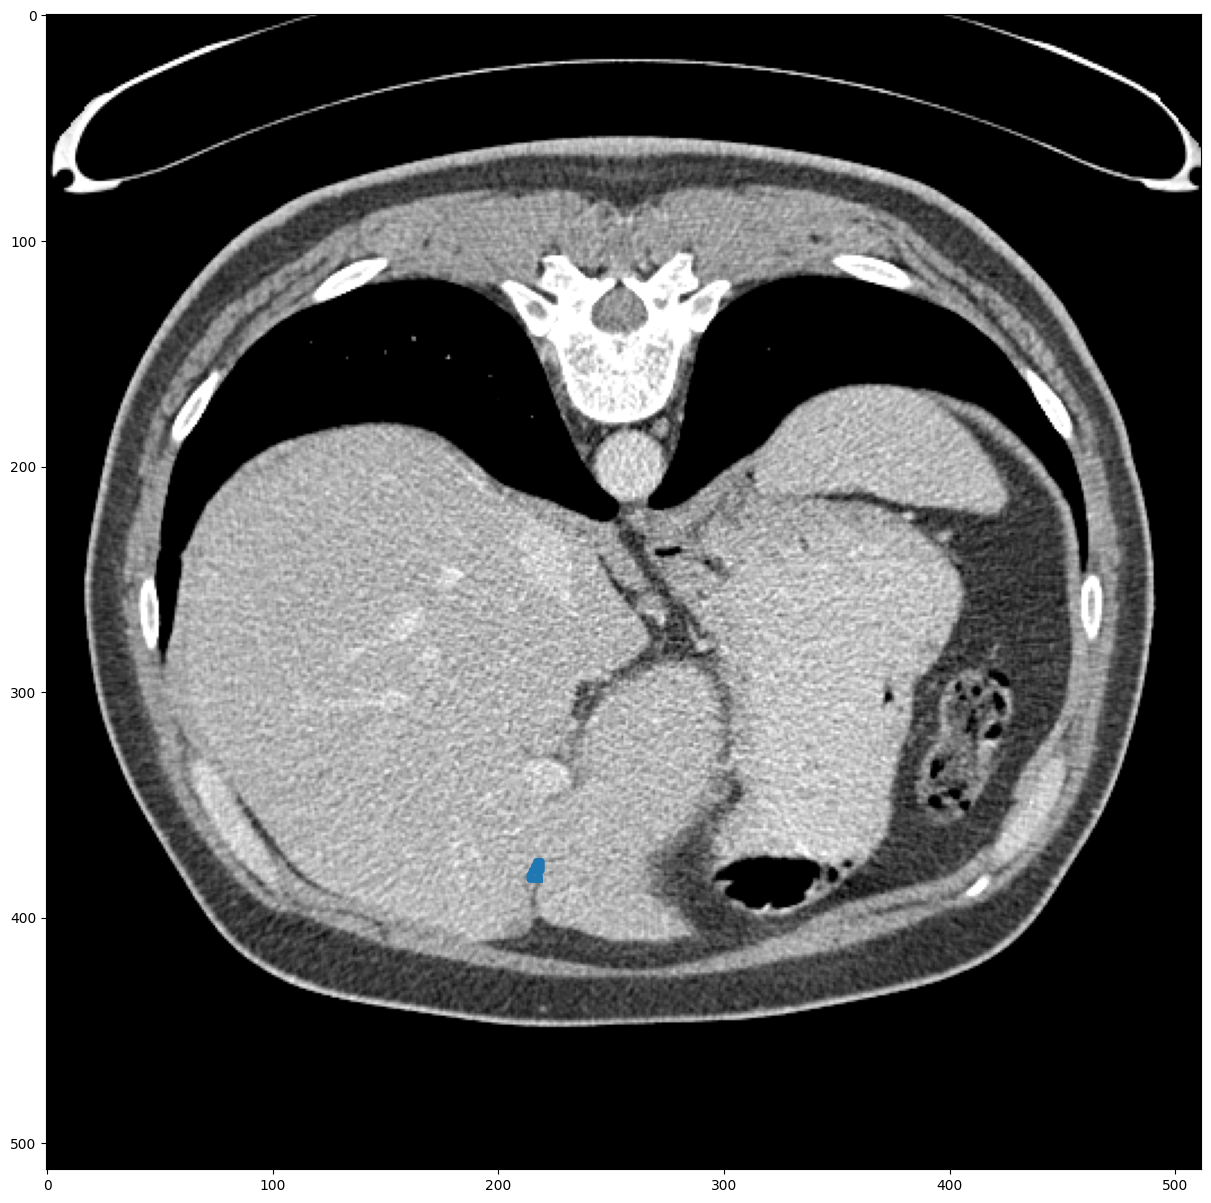

In [24]:
slices = [425,400,416]
for i,file_id in enumerate(idxxxx):
    volume_1 = reading_data(files_volume[file_id])
    print(volume_1.shape)
    volume_1 = preprocessing_3d(volume_1)
    seg_1 = reading_data(files_segmenation[file_id])
    seg_1 = label_seperator_lesion(seg_1)
    seg_1 = tf.keras.utils.to_categorical(seg_1, 2)
    slice = slices[i]
    lesion = np.load(f"{file_id}_preds.npy")
    AA = np.where(lesion[slice, :, :,1]>0.3,1,0)
    print(AA.shape)

    overlays = []
    for contour in find_contours(AA, level=0.9999):
        c = np.expand_dims(contour.astype(np.float32), 1)
        # Convert it to UMat object
        c = cv2.UMat(c)
        area = cv2.contourArea(c)
        if area > 50:
            overlays.append(ImagejRoi.frompoints(np.round(contour)[:, ::-1]).tobytes())
            print(area,"ok countur")
        else:
            print(area,"regected")
        


    """volume_1[slice, :, :, 0]
    lesion[slice, :, :]
    """

    plot_image_overlays(volume_1[slice, :, :, 0], overlays, lw=5)

    # write the image and overlays to a new ImageJ TIFF file
    imwrite(f"{file_id}_roi_test.tif", volume_1[slice, :, :, 0], imagej=True, metadata={'Overlays': overlays})
    imwrite(f"{file_id}_roi_gt.tif", seg_1[slice, :, :, 1], imagej=True, metadata={'Overlays': overlays})